# Data preparation, no need to run

In [ ]:
### Setup the Environment

!pip install numpy pandas tensorflow keras opencv-python scikit-learn matplotlib
!pip install torch torchvision
!pip install pandas
!pip install -r ./yolov5/requirements.txt
!pip install tqdm
!pip install imgaug

In [ ]:
import os
import pandas as pd
import numpy as np
import cv2
from tensorflow.keras.utils import to_categorical
import shutil
import sys
import torch
from tqdm import tqdm
import albumentations as A
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage


In [ ]:
# Paths
train_annotations_path = './train_coco_annotations.csv'
valid_annotations_path = './valid_coco_annotations.csv'
train_folder = './data/train/'
valid_folder = './data/valid/'
yolo_data_folder = './yolo_data/'

# Create new YOLO data folders
train_images_folder = os.path.join(yolo_data_folder, 'train/images/')
train_labels_folder = os.path.join(yolo_data_folder, 'train/labels/')
valid_images_folder = os.path.join(yolo_data_folder, 'valid/images/')
valid_labels_folder = os.path.join(yolo_data_folder, 'valid/labels/')

os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_labels_folder, exist_ok=True)
os.makedirs(valid_images_folder, exist_ok=True)
os.makedirs(valid_labels_folder, exist_ok=True)

# Filter and save volume bounding boxes
volume_bboxes = []

# Function to copy and convert COCO annotations to YOLO format
def process_annotations(annotations_path, src_folder, dest_images_folder, dest_labels_folder, dataset_name):
    annotations = pd.read_csv(annotations_path)
    total_annotations = len(annotations)

    for idx, row in enumerate(annotations.iterrows(), start=1):
        _, row_data = row
        image_id = row_data['FileName']
        bbox = eval(row_data['BBox'])  # Convert BBox string to list
        class_id = row_data['Category']  # 0 for holds, 1 for volumes

        # Filter for volumes
        if class_id == 1:
            volume_bboxes.append((image_id, bbox))  # Store for augmentation

        src_image_path = os.path.join(src_folder, image_id)
        dest_image_path = os.path.join(dest_images_folder, image_id)
        yolo_label_path = os.path.join(dest_labels_folder, os.path.splitext(image_id)[0] + ".txt")

        # Copy image
        if os.path.exists(src_image_path):
            shutil.copy(src_image_path, dest_image_path)

            # Load image to get dimensions
            image = cv2.imread(src_image_path)
            if image is not None:
                img_height, img_width = image.shape[:2]

                # Convert bbox to YOLO format
                x, y, w, h = bbox
                x_center = (x + w / 2) / img_width
                y_center = (y + h / 2) / img_height
                width = w / img_width
                height = h / img_height

                # Write YOLO annotation
                with open(yolo_label_path, "a") as yolo_file:
                    yolo_file.write(f"{class_id} {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")
            else:
                print(f"Could not load image: {src_image_path}")
        else:
            print(f"Image not found: {src_image_path}")

        # Calculate and display progress
        progress = (idx / total_annotations) * 100
        print(f"[{dataset_name}] Progress: {progress:.2f}% ({idx}/{total_annotations})", end="\r")

    print(f"\n[{dataset_name}] Processing completed.")

# Process training data
process_annotations(train_annotations_path, train_folder, train_images_folder, train_labels_folder, "Training")

# Process validation data
process_annotations(valid_annotations_path, valid_folder, valid_images_folder, valid_labels_folder, "Validation")

print("Dataset organized and annotations converted to YOLO format.")


[Training] Progress: 100.00% (129868/129868)
[Training] Processing completed.
[Validation] Progress: 100.00% (11335/11335)
[Validation] Processing completed.
Dataset organized and annotations converted to YOLO format.


In [22]:
volume_bboxes

[('4LdnAMptWBNb9XmQQ_jpg.rf.ceadae1e2d71deacc9b51f4a9630f850.jpg',
  [207, 137, 143, 126]),
 ('2022-12-09_14-36-34_UTC_jpg.rf.cf5ee360a7c6ac8dd5e5a0cbdd9b1646.jpg',
  [293, 104, 225.98, 157.46]),
 ('2022-12-09_14-36-34_UTC_jpg.rf.cf5ee360a7c6ac8dd5e5a0cbdd9b1646.jpg',
  [538, 263, 41.22, 59.25]),
 ('3nvGmAZadBMQoEZwi_jpg.rf.cf32b233b5972b6052f7bff6e07c3dbd.jpg',
  [416, 621, 149, 166]),
 ('3nvGmAZadBMQoEZwi_jpg.rf.cf32b233b5972b6052f7bff6e07c3dbd.jpg',
  [327, 554, 153, 175]),
 ('3nvGmAZadBMQoEZwi_jpg.rf.cf32b233b5972b6052f7bff6e07c3dbd.jpg',
  [478, 459, 108, 124]),
 ('3nvGmAZadBMQoEZwi_jpg.rf.cf32b233b5972b6052f7bff6e07c3dbd.jpg',
  [225, 585, 83, 88]),
 ('3nvGmAZadBMQoEZwi_jpg.rf.cf32b233b5972b6052f7bff6e07c3dbd.jpg',
  [251, 451, 122, 129]),
 ('3nvGmAZadBMQoEZwi_jpg.rf.cf32b233b5972b6052f7bff6e07c3dbd.jpg',
  [144, 363, 124, 114]),
 ('3nvGmAZadBMQoEZwi_jpg.rf.cf32b233b5972b6052f7bff6e07c3dbd.jpg',
  [301, 126, 147, 119]),
 ('3nvGmAZadBMQoEZwi_jpg.rf.cf32b233b5972b6052f7bff6e07c3dbd

### Data Augmentation
- Due to unbalanced dataset (fewer "volumes" comparing to holds), we here specifically augmented volumes images.

In [26]:
# Define augmentations
augmenters = iaa.Sequential([
    iaa.Fliplr(0.5),  # Horizontal flip
    iaa.Affine(scale=(0.8, 1.2), translate_percent=(-0.2, 0.2), rotate=(-15, 15)),  # Scale, translate, rotate
    iaa.Multiply((0.8, 1.2)),  # Adjust brightness
])

# Output folders
train_images_folder = './augmented_images'
train_labels_folder = './augmented_labels'

os.makedirs(train_images_folder, exist_ok=True)
os.makedirs(train_labels_folder, exist_ok=True)

# Process each image and its bounding boxes
for image_id, bbox in tqdm(volume_bboxes, desc="Augmenting images"):
    # Load the image
    src_image_path = os.path.join('./data/train', image_id)
    image = cv2.imread(src_image_path)
    if image is None:
        continue

    img_height, img_width = image.shape[:2]

    # Convert bounding box from [x_min, y_min, w, h] to [x_min, y_min, x_max, y_max]
    x_min, y_min, w, h = bbox
    x_max = x_min + w
    y_max = y_min + h

    # Create BoundingBoxesOnImage object
    bbs = BoundingBoxesOnImage([
        BoundingBox(x1=x_min, y1=y_min, x2=x_max, y2=y_max)
    ], shape=image.shape)

    try:
        # Apply augmentation
        image_aug, bbs_aug = augmenters(image=image, bounding_boxes=bbs)
    except Exception as e:
        continue

    # Convert augmented bounding boxes back to YOLO format
    augmented_bboxes = []
    for bb in bbs_aug:
        bb = bb.clip_out_of_image(image.shape)  # Pass image.shape to clip bounding box
        if bb.is_out_of_image(image.shape):  # Skip completely invalid bounding boxes
            continue
        x_min, y_min, x_max, y_max = bb.x1, bb.y1, bb.x2, bb.y2
        w = x_max - x_min
        h = y_max - y_min
        augmented_bboxes.append([x_min, y_min, w, h])

    # Skip if no valid bounding boxes remain
    if not augmented_bboxes:
        continue

    # Save the augmented image
    aug_image_id = f"aug_{os.path.basename(image_id)}"
    augmented_image_path = os.path.join(train_images_folder, aug_image_id)
    cv2.imwrite(augmented_image_path, image_aug)

    # Save augmented annotations in YOLO format
    aug_label_path = os.path.join(train_labels_folder, f"{os.path.splitext(aug_image_id)[0]}.txt")
    with open(aug_label_path, "w") as f:
        for x_min, y_min, w, h in augmented_bboxes:
            x_center = (x_min + w / 2) / img_width
            y_center = (y_min + h / 2) / img_height
            width = w / img_width
            height = h / img_height
            f.write(f"1 {x_center:.6f} {y_center:.6f} {width:.6f} {height:.6f}\n")

print(f"\nTotal images processed: {len(volume_bboxes)}")

Augmenting images:  91%|█████████ | 9341/10254 [02:11<00:14, 61.19it/s][ WARN:0@4416.212] global loadsave.cpp:241 findDecoder imread_('./data/train/745_jpg.rf.005622bff6f8f531cacd49914a8b0054.jpg'): can't open/read file: check file path/integrity
[ WARN:0@4416.214] global loadsave.cpp:241 findDecoder imread_('./data/train/722_jpg.rf.0235f7e7f736a73f56e76e9f7632cb27.jpg'): can't open/read file: check file path/integrity
[ WARN:0@4416.214] global loadsave.cpp:241 findDecoder imread_('./data/train/722_jpg.rf.0235f7e7f736a73f56e76e9f7632cb27.jpg'): can't open/read file: check file path/integrity
[ WARN:0@4416.214] global loadsave.cpp:241 findDecoder imread_('./data/train/5f4mCCjnTBzxGmAjM_jpg.rf.006ed3ee606e9814c9b00eb3ec4925ff.jpg'): can't open/read file: check file path/integrity
[ WARN:0@4416.214] global loadsave.cpp:241 findDecoder imread_('./data/train/5f4mCCjnTBzxGmAjM_jpg.rf.006ed3ee606e9814c9b00eb3ec4925ff.jpg'): can't open/read file: check file path/integrity
[ WARN:0@4416.214] gl


Total images processed: 10254


In [ ]:
# Paths to original and augmented data
original_images_folder = './yolo_data/train/images'
original_labels_folder = './yolo_data/train/labels'
augmented_images_folder = './augmented_images'
augmented_labels_folder = './augmented_labels'

# Merge augmented images into the training images folder
for file in os.listdir(augmented_images_folder):
    shutil.copy(os.path.join(augmented_images_folder, file), original_images_folder)

# Merge augmented labels into the training labels folder
for file in os.listdir(augmented_labels_folder):
    shutil.copy(os.path.join(augmented_labels_folder, file), original_labels_folder)

print("Augmented data merged successfully!")

Augmented data merged successfully!


In [29]:
image_files = set(os.listdir('./yolo_data/train/images'))
label_files = set(os.listdir('./yolo_data/train/labels'))

# Strip extensions for comparison
image_ids = {os.path.splitext(f)[0] for f in image_files}
label_ids = {os.path.splitext(f)[0] for f in label_files}

missing_labels = image_ids - label_ids
if missing_labels:
    print(f"Images without labels: {missing_labels}")
else:
    print("All images have corresponding labels!")

All images have corresponding labels!


In [30]:
import os

# Path to the folder containing YOLO labels
train_labels_folder = './yolo_data/train/labels'

# Initialize counters
class_counts = {"holds": 0, "volumes": 0}

# Iterate over label files
for label_file in os.listdir(train_labels_folder):
    label_path = os.path.join(train_labels_folder, label_file)
    with open(label_path, 'r') as f:
        for line in f:
            class_id = int(line.split()[0])  # Class ID is the first value in each line
            if class_id == 0:
                class_counts["holds"] += 1
            elif class_id == 1:
                class_counts["volumes"] += 1

# Print results
print(f"Total annotations for 'holds': {class_counts['holds']}")
print(f"Total annotations for 'volumes': {class_counts['volumes']}")


Total annotations for 'holds': 520074
Total annotations for 'volumes': 42333


### Load Dataset
- Reads image files and their corresponding label files in YOLO format.
- Resizes images to a consistent size (`640x640`).

### Oversample Minority Class
- Identifies images containing a specific class (e.g., "volumes") using the class ID.
- Duplicates these images in the dataset (`oversample_factor`) to balance class frequencies.

### Prepare Data for Training
- Converts images to tensors and normalizes pixel values.
- Converts bounding box labels into tensors for compatibility with PyTorch.

### Handle Variable-Sized Labels
- Implements a custom `collate_fn` to handle batches of data with varying numbers of bounding boxes per image.


In [36]:
from torch.utils.data import DataLoader
import torch
import cv2
import os
import numpy as np

class YoloDataset(Dataset):
    def __init__(self, image_dir, label_dir, class_to_oversample=1, oversample_factor=2, transform=None, img_size=(640, 640)):
        self.image_dir = image_dir
        self.label_dir = label_dir
        self.transform = transform
        self.img_size = img_size  # Target size for resizing
        self.class_to_oversample = class_to_oversample
        self.oversample_factor = oversample_factor

        # Load all images and labels
        self.images = os.listdir(image_dir)
        self.labels = os.listdir(label_dir)

        # Map images to their labels
        self.data = [
            (os.path.join(image_dir, img), os.path.join(label_dir, f"{os.path.splitext(img)[0]}.txt"))
            for img in self.images
            if os.path.exists(os.path.join(label_dir, f"{os.path.splitext(img)[0]}.txt"))
        ]

        # Identify images containing the class to oversample
        self.oversample_data = []
        for img_path, label_path in self.data:
            with open(label_path, 'r') as f:
                for line in f:
                    class_id = int(line.split()[0])  # Class ID is the first value in each line
                    if class_id == self.class_to_oversample:
                        self.oversample_data.append((img_path, label_path))
                        break

        # Combine original data with oversampled data
        self.data += self.oversample_data * (self.oversample_factor - 1)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        img_path, label_path = self.data[idx]
        image = cv2.imread(img_path)
        if image is None:
            raise ValueError(f"Could not read image: {img_path}")

        # Resize or pad image to fixed size
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = cv2.resize(image, self.img_size)  # Resize image to fixed size

        with open(label_path, 'r') as f:
            labels = []
            for line in f:
                class_id, x_center, y_center, width, height = map(float, line.strip().split())
                # Adjust label coordinates if resizing
                labels.append([class_id, x_center, y_center, width, height])

        labels = torch.tensor(labels)

        # Apply transformations if specified
        if self.transform:
            image = self.transform(image)

        # Convert image to tensor and normalize
        image = torch.tensor(image).permute(2, 0, 1).float() / 255.0

        return image, labels


def collate_fn(batch):
    """
    Custom collate function to handle variable-sized labels (bounding boxes).
    """
    images = torch.stack([item[0] for item in batch])  # Stack images into a tensor
    labels = [item[1] for item in batch]  # Keep labels as a list of tensors
    return images, labels


# Initialize Dataset and DataLoader
if __name__ == "__main__":
    # Paths to training data
    train_image_dir = './yolo_data/train/images'
    train_label_dir = './yolo_data/train/labels'

    dataset = YoloDataset(
        image_dir=train_image_dir,
        label_dir=train_label_dir,
        class_to_oversample=1,  # Oversample 'volumes' class
        oversample_factor=2,   # Oversample each 'volumes' image twice
        img_size=(640, 640)    # Target size for resizing
    )
    dataloader = DataLoader(dataset, batch_size=16, shuffle=True, collate_fn=collate_fn)

    # Iterate through DataLoader
    for images, labels in dataloader:
        print(f"Batch size: {len(images)}")
        print(f"First image shape: {images[0].shape}")
        print(f"Labels for first batch item: {labels[0]}")
        break



Batch size: 16
First image shape: torch.Size([3, 640, 640])
Labels for first batch item: tensor([[0.0000, 0.5117, 0.4910, 0.9767, 0.9420],
        [0.0000, 0.5117, 0.4910, 0.9767, 0.9420],
        [0.0000, 0.5117, 0.4910, 0.9767, 0.9420],
        [0.0000, 0.5117, 0.4910, 0.9767, 0.9420]])


In [38]:
if __name__ == "__main__":
    # Paths to training data
    train_image_dir = './yolo_data/train/images'
    train_label_dir = './yolo_data/train/labels'

    # Initialize Dataset
    dataset = YoloDataset(
        image_dir=train_image_dir,
        label_dir=train_label_dir,
        class_to_oversample=1,  # Oversample 'volumes' class
        oversample_factor=2,   # Oversample each 'volumes' image twice
        img_size=(640, 640)    # Target size for resizing
    )

    # Initialize DataLoader with custom collate_fn
    dataloader = DataLoader(
        dataset, 
        batch_size=16, 
        shuffle=True, 
        collate_fn=collate_fn  # Use the custom collate function
    )

    # Iterate through DataLoader
    for images, labels in dataloader:
        print(f"Batch size: {len(images)}")
        print(f"First image shape: {images[0].shape}")
        print(f"Labels for first batch item: {labels[0]}")
        break

Batch size: 16
First image shape: torch.Size([3, 640, 640])
Labels for first batch item: tensor([[0.0000, 0.6721, 0.7625, 0.1539, 0.3750],
        [0.0000, 0.5158, 0.7500, 0.1418, 0.3900],
        [0.0000, 0.3976, 0.7013, 0.1212, 0.3725],
        [0.0000, 0.2630, 0.6712, 0.1455, 0.3875],
        [0.0000, 0.1406, 0.6263, 0.1212, 0.3625],
        [0.0000, 0.7152, 0.3700, 0.1430, 0.4250],
        [0.0000, 0.5855, 0.3450, 0.1479, 0.4650],
        [0.0000, 0.4261, 0.3050, 0.1467, 0.4500],
        [0.0000, 0.2933, 0.2637, 0.1333, 0.4375],
        [0.0000, 0.1521, 0.2400, 0.1564, 0.4650],
        [0.0000, 0.6721, 0.7625, 0.1539, 0.3750],
        [0.0000, 0.5158, 0.7500, 0.1418, 0.3900],
        [0.0000, 0.3976, 0.7013, 0.1212, 0.3725],
        [0.0000, 0.2630, 0.6712, 0.1455, 0.3875],
        [0.0000, 0.1406, 0.6263, 0.1212, 0.3625],
        [0.0000, 0.7152, 0.3700, 0.1430, 0.4250],
        [0.0000, 0.5855, 0.3450, 0.1479, 0.4650],
        [0.0000, 0.4261, 0.3050, 0.1467, 0.4500],
        [0.

### Visualize Examples

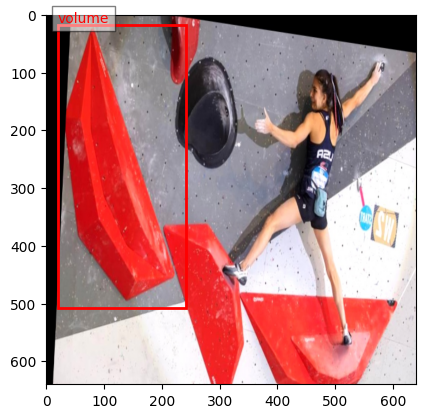

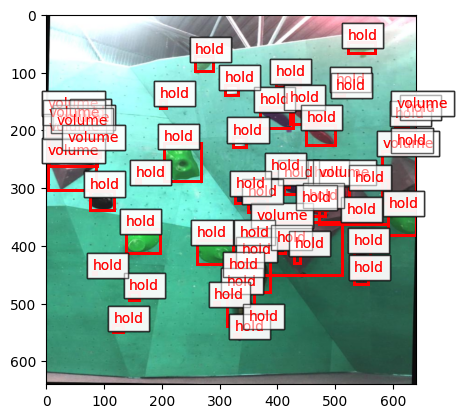

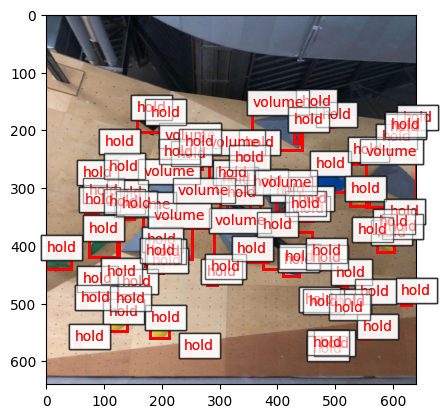

In [39]:
import matplotlib.pyplot as plt

def visualize_sample(image, labels, class_names=["hold", "volume"]):
    """
    Visualize an image with bounding boxes.
    Args:
        image (Tensor): Image tensor of shape [3, H, W].
        labels (Tensor): Bounding box tensor of shape [N, 5].
        class_names (list): List of class names.
    """
    image = image.permute(1, 2, 0).numpy()  # Convert to HWC format
    plt.imshow(image)

    for label in labels:
        class_id, x_center, y_center, width, height = label
        x_min = (x_center - width / 2) * image.shape[1]
        y_min = (y_center - height / 2) * image.shape[0]
        x_max = (x_center + width / 2) * image.shape[1]
        y_max = (y_center + height / 2) * image.shape[0]

        # Draw bounding box
        rect = plt.Rectangle(
            (x_min, y_min), x_max - x_min, y_max - y_min, 
            edgecolor="red", facecolor="none", linewidth=2
        )
        plt.gca().add_patch(rect)
        plt.text(
            x_min, y_min - 5, class_names[int(class_id)],
            color="red", fontsize=10, bbox=dict(facecolor="white", alpha=0.5)
        )
    plt.show()

# Visualize a batch
for images, labels in dataloader:
    for i in range(3):  # Visualize the first 3 images in the batch
        visualize_sample(images[i], labels[i])
    break


### Class Distribution After Oversampling

In [40]:
from collections import Counter

def check_class_distribution(dataset):
    """
    Check the distribution of classes (e.g., volumes vs. holds) in the dataset.
    Args:
        dataset: YoloDataset instance.
    Returns:
        dict: Count of instances for each class.
    """
    class_counts = Counter()

    for _, labels in dataset:
        for label in labels:
            class_id = int(label[0])  # First element in label is the class ID
            class_counts[class_id] += 1

    return class_counts

if __name__ == "__main__":
    # Paths to training data
    train_image_dir = './yolo_data/train/images'
    train_label_dir = './yolo_data/train/labels'

    # Initialize the dataset
    dataset = YoloDataset(
        image_dir=train_image_dir,
        label_dir=train_label_dir,
        class_to_oversample=1,  # Oversample 'volumes' class
        oversample_factor=2,   # Oversample each 'volumes' image twice
        img_size=(640, 640)    # Target size for resizing
    )

    # Check class distribution
    distribution = check_class_distribution(dataset)
    print(f"Class distribution after oversampling: {distribution}")


Class distribution after oversampling: Counter({0: 851597, 1: 84666})


# Data Configuration
- Adjust Class Weights
    - Since holds (class 0) are significantly more frequent than volumes (class 1), we adjust the class weights in the loss function to prioritize learning the minority class (volumes).
-  hyp.yaml
    - cls: 1.5   # Increased for minority class 'volumes'

# Run YOLO in yolov5 folder

- Code for running YOLO  
python train.py --img 640 --batch 16 --epochs 50 --data yolo_data/data.yaml --weights yolov5s.pt --project runs --name hold_volume_detection

- current:   
python train.py --img 416 --batch 8 --epochs 10 --data yolo_data/data.yaml --weights yolov5n.pt --project runs --name hold_volume_detection --workers 4
Results saved to runs\hold_volume_detection5

python train.py --img 416 --batch 8 --epochs 10 --data ./yolo_data/data.yaml --cfg ./models/yolov5s.yaml --weights yolov5s.pt --hyp ./runs/hold_volume_detection8/hyp.yaml --workers 4

- to resume a run  
python train.py --resume

- can try this  
python train.py --img 416 --batch 8 --epochs 10 --data yolo_data/data.yaml --weights yolov5n.pt --hyp hyp.scratch-low.yaml --workers 4



- Results saved to runs\hold_volume_detection5

10 epochs completed in 0.818 hours.
Optimizer stripped from runs\hold_volume_detection5\weights\last.pt, 3.7MB
Optimizer stripped from runs\hold_volume_detection5\weights\best.pt, 3.7MB

Validating runs\hold_volume_detection5\weights\best.pt...
Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
                 Class     Images  Instances          P          R      mAP50   mAP50-95: 100%|██████████| 18/18 [00:09<00:00,  1.93it/s]
                   all        277      11335      0.782      0.616      0.683      0.409
                  hold        277      10421      0.755      0.638      0.665       0.38
                volume        277        914      0.809      0.595        0.7      0.439
Results saved to runs\hold_volume_detection5

# Make predictions

In [44]:
# Determine the current working directory
script_dir = os.getcwd()


# Change directory to the YOLOv5 folder
yolo_folder = os.path.join(script_dir, "yolov5")
os.chdir(yolo_folder)

In [45]:

# Verify the working directory
print(f"Changed working directory to: {os.getcwd()}")

# Add YOLOv5 folder to Python path
yolov5_path = os.path.join(script_dir, "yolov5")
sys.path.append(yolov5_path)

# Import YOLOv5 components
from models.common import DetectMultiBackend

# Set paths
model_path = os.path.join(yolov5_path, "runs/hold_volume_detection8/weights/best.pt")
input_folder = os.path.join(yolov5_path, "data/test_image")
output_folder = os.path.join(yolov5_path, "data/test_output")
os.makedirs(output_folder, exist_ok=True)

print("Setup complete!")

Changed working directory to: /Users/apple/Desktop/si670_final_project/yolov5


  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  5433    0  1977  100  3456   3930   6870 --:--:-- --:--:-- --:--:-- 10801
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0     0    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0

<!DOCTYPE html>
<html>
<head>
    <title>Error: Request limit exceeded. Sign up to unlock more requests. - Webhook.site</title>
    <link href="https://cdn.webhook.site/css/app.css" rel="stylesheet">
</head>
<body>
<div class="container" style="padding: 50px">
    <div class="row">
        <div class="col-sm-12 text-center">
            <h1><img src="https://cdn.webhook.site/icon.png" alt="Webhook.site Logo" style="width:40px; margin-top: -5px">
                Webhook.site Error</h1>

            <p class="lead">Request limit exceeded. Sign up to unlock more requests.</p>
        </div>
    </div>
    <div class="row">
        <div class="col-sm-4 col-sm-offset-4 text-center">
                            <p>
                        You have been rate limited due to too many requests to this URL.
    This is either because you have not purchased
    a Webhook.site subscription, or the endpoint has a rate limit.<br>
    <br>
    To remove the request limit limit, you can upgrade to a We

100  4577    0  1977  100  2600   4654   6120 --:--:-- --:--:-- --:--:-- 10794


<!DOCTYPE html>
<html>
<head>
    <title>Error: Request limit exceeded. Sign up to unlock more requests. - Webhook.site</title>
    <link href="https://cdn.webhook.site/css/app.css" rel="stylesheet">
</head>
<body>
<div class="container" style="padding: 50px">
    <div class="row">
        <div class="col-sm-12 text-center">
            <h1><img src="https://cdn.webhook.site/icon.png" alt="Webhook.site Logo" style="width:40px; margin-top: -5px">
                Webhook.site Error</h1>

            <p class="lead">Request limit exceeded. Sign up to unlock more requests.</p>
        </div>
    </div>
    <div class="row">
        <div class="col-sm-4 col-sm-offset-4 text-center">
                            <p>
                        You have been rate limited due to too many requests to this URL.
    This is either because you have not purchased
    a Webhook.site subscription, or the endpoint has a rate limit.<br>
    <br>
    To remove the request limit limit, you can upgrade to a We

In [52]:
# Load the YOLOv5 model
model = DetectMultiBackend(model_path, device=torch.device('cpu'))
print("Model loaded successfully!")

Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs


Model loaded successfully!


In [53]:
# Initialize statistics
stats = {"class": [], "confidence": [], "image": [], "x1": [], "y1": [], "x2": [], "y2": [], "cls": []}

# Loop through all images in the input folder
image_files = [f for f in os.listdir(input_folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]
for image_name in tqdm(image_files, desc="Processing images", unit="image"):
    try:
        image_path = os.path.join(input_folder, image_name)

        # Load image
        img = cv2.imread(image_path)
        if img is None:
            print(f"Warning: Unable to read image {image_name}. Skipping.")
            continue
        img_height, img_width = img.shape[:2]

        # Preprocess image for YOLO
        img_resized = cv2.resize(img, (416, 416))  # Resize to YOLO input size
        img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0)  # Normalize and add batch dimension

        # Run inference
        results = model(img_tensor)

        # Process predictions
        for det in results[0]:  # Get the first level of predictions
            # Ensure det is a tensor and process it
            if isinstance(det, torch.Tensor):
                det = det.cpu().numpy()  # Convert tensor to numpy array

            for pred in det:  # Iterate through individual predictions
                # Extract relevant values: bbox, confidence, and class
                if pred.shape[0] >= 6:  # Ensure there are enough elements
                    x_center, y_center, width, height = pred[:4]
                    conf = pred[4]  # Fifth value is confidence
                    cls = pred[5]  # Sixth value is class index

                    

                    # Confidence threshold
                    if conf < 0.5:  # Ignore predictions with low confidence
                        continue

                    # Convert from center-size format to corner coordinates
                    x1 = int((x_center - width / 2) / 416 * img_width)
                    y1 = int((y_center - height / 2) / 416 * img_height)
                    x2 = int((x_center + width / 2) / 416 * img_width)
                    y2 = int((y_center + height / 2) / 416 * img_height)

                    class_id = 0 if cls <= 0.5 else 1  # 0 for holds, 1 for volumes

                    # Save bounding box locations
                    stats["class"].append(int(class_id))
                    stats["confidence"].append(float(conf))
                    stats["image"].append(image_name)
                    stats["x1"].append(x1)
                    stats["y1"].append(y1)
                    stats["x2"].append(x2)
                    stats["y2"].append(y2)
                    stats["cls"].append(cls)

                    label = f"{'Hold' if cls <= 0.5 else 'Volume'} {conf:.2f}"
                    color = (255, 0, 0) if label=='Hold' else (0, 0, 255)  # Blue for holds, red for volumes
                    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
                    # Draw bounding boxes
                    cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

        # Save the annotated image
        output_path = os.path.join(output_folder, image_name)
        cv2.imwrite(output_path, img)

    except Exception as e:
        print(f"Error processing {image_name}: {e}")

# Save statistics to a CSV file
stats_df = pd.DataFrame(stats)
stats_df.to_csv(os.path.join(output_folder, "test_statistics.csv"), index=False)

print(f"Processed {len(image_files)} images. Results saved to {output_folder}.")


Processing images: 100%|██████████| 148/148 [00:14<00:00, 10.44image/s]


Processed 148 images. Results saved to /Users/apple/Desktop/si670_final_project/yolov5/data/test_output.


In [54]:
def iou(box1, box2):
    """
    Calculate Intersection over Union (IoU) between two bounding boxes.
    box1, box2: (x1, y1, x2, y2)
    """
    x1_inter = max(box1[0], box2[0])
    y1_inter = max(box1[1], box2[1])
    x2_inter = min(box1[2], box2[2])
    y2_inter = min(box1[3], box2[3])

    inter_area = max(0, x2_inter - x1_inter + 1) * max(0, y2_inter - y1_inter + 1)
    box1_area = (box1[2] - box1[0] + 1) * (box1[3] - box1[1] + 1)
    box2_area = (box2[2] - box2[0] + 1) * (box2[3] - box2[1] + 1)
    union_area = box1_area + box2_area - inter_area

    return inter_area / union_area if union_area != 0 else 0



In [55]:
def non_maximum_suppression(df, iou_threshold=0.5):
    """
    Apply Non-Maximum Suppression (NMS) to the bounding boxes in a DataFrame.
    df: DataFrame containing 'x1', 'y1', 'x2', 'y2', 'confidence', 'class', 'image'
    iou_threshold: IoU threshold to suppress overlapping boxes
    """
    nms_results = []

    # Process each image separately
    for image, group in df.groupby('image'):
        boxes = group[['x1', 'y1', 'x2', 'y2']].values
        confidences = group['confidence'].values
        classes = group['class'].values

        # Sort boxes by confidence score in descending order
        indices = confidences.argsort()[::-1]
        boxes = boxes[indices]
        confidences = confidences[indices]
        classes = classes[indices]
        group = group.iloc[indices]  # Sort the group DataFrame accordingly

        suppressed = set()
        for i in range(len(boxes)):
            if i in suppressed:
                continue
            current_box = boxes[i]
            nms_results.append(group.iloc[i])  # Keep the box with the highest confidence
            for j in range(i + 1, len(boxes)):
                if j in suppressed:
                    continue
                iou_score = iou(current_box, boxes[j])
                # Suppress boxes based on IoU only, ignoring class differences
                if iou_score > iou_threshold:
                    suppressed.add(j)

    # Convert the results back to a DataFrame
    return pd.DataFrame(nms_results)


In [56]:
# Load the statistics DataFrame
stats_path = os.path.join(output_folder, "test_statistics.csv")
stats_df = pd.read_csv(stats_path)

# Apply NMS
nms_df = non_maximum_suppression(stats_df, iou_threshold=0.5)

# Save the NMS results to a new CSV file
nms_path = os.path.join(output_folder, "nms_statistics.csv")
nms_df.to_csv(nms_path, index=False)

print(f"NMS applied. Results saved to {nms_path}.")

NMS applied. Results saved to /Users/apple/Desktop/si670_final_project/yolov5/data/test_output/nms_statistics.csv.


# Post Processing

In [247]:
def improved_non_maximum_suppression(df, iou_threshold=0.5, sigma=0.5):
    """
    Apply Non-Maximum Suppression (NMS) with improved confidence calculation.

    Args:
        df: DataFrame containing 'x1', 'y1', 'x2', 'y2', 'confidence', 'class', 'image'.
        iou_threshold: IoU threshold for suppressing overlapping boxes.
        sigma: Decay rate for soft confidence adjustment.

    Returns:
        A DataFrame containing the filtered bounding boxes with improved confidence logic.
    """
    nms_results = []

    # Process each image separately
    for image, group in df.groupby('image'):
        boxes = group[['x1', 'y1', 'x2', 'y2']].values
        confidences = group['confidence'].values
        classes = group['class'].values

        # Sort boxes by confidence score in descending order
        indices = confidences.argsort()[::-1]
        boxes = boxes[indices]
        confidences = confidences[indices]
        classes = classes[indices]
        group = group.iloc[indices]  # Sort the group DataFrame accordingly

        suppressed = set()
        for i in range(len(boxes)):
            if i in suppressed:
                continue
            current_box = boxes[i]
            current_confidence = confidences[i]
            weighted_confidence = current_confidence  # Initialize with original confidence

            # Keep the box with the highest confidence
            nms_results.append(group.iloc[i])

            for j in range(i + 1, len(boxes)):
                if j in suppressed:
                    continue

                iou_score = iou(current_box, boxes[j])
                if iou_score > iou_threshold:
                    # Adjust confidence based on overlap using a soft suppression formula
                    confidences[j] *= np.exp(-iou_score**2 / sigma) + 0.1
                    
                    # Update the weighted confidence for the current box
                    weighted_confidence += confidences[j] * np.exp(-iou_score**2 / sigma)
                    
                    suppressed.add(j)

            # Update confidence of the selected box in the results
            nms_results[-1]['confidence'] = weighted_confidence

    # Convert the results back to a DataFrame
    return pd.DataFrame(nms_results)


# Apply the improved NMS
nms_df_improved = improved_non_maximum_suppression(stats_df, iou_threshold=0.5)

# Save the results to a new CSV file
nms_path = os.path.join(output_folder, "nms_statistics_improved.csv")
nms_df_improved.to_csv(nms_path, index=False)

print(f"Improved NMS applied. Results saved to {nms_path}.")

/var/folders/pg/xznxg07956n15xkrst1hdvvm0000gn/T/ipykernel_51852/1671067339.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nms_results[-1]['confidence'] = weighted_confidence
/var/folders/pg/xznxg07956n15xkrst1hdvvm0000gn/T/ipykernel_51852/1671067339.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nms_results[-1]['confidence'] = weighted_confidence
/var/folders/pg/xznxg07956n15xkrst1hdvvm0000gn/T/ipykernel_51852/1671067339.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_g

Improved NMS applied. Results saved to /Users/apple/Desktop/si670_final_project/yolov5/data/test_output/nms_statistics_improved.csv.


In [ ]:
def improved_non_maximum_suppression(df, iou_threshold=0.4, sigma=0.4):
    """
    Apply Non-Maximum Suppression (NMS) with improved confidence and class recalculation.

    Args:
        df: DataFrame containing 'x1', 'y1', 'x2', 'y2', 'confidence', 'class', 'image'.
        iou_threshold: IoU threshold for suppressing overlapping boxes.
        sigma: Decay rate for soft confidence adjustment.

    Returns:
        A DataFrame containing the filtered bounding boxes with recalculated confidence and class.
    """
    nms_results = []

    # Process each image separately
    for image, group in df.groupby('image'):
        boxes = group[['x1', 'y1', 'x2', 'y2']].values
        confidences = group['confidence'].values
        classes = group['class'].values

        # Sort boxes by confidence score in descending order
        indices = confidences.argsort()[::-1]
        boxes = boxes[indices]
        confidences = confidences[indices]
        classes = classes[indices]
        group = group.iloc[indices]  # Sort the group DataFrame accordingly

        suppressed = set()
        for i in range(len(boxes)):
            if i in suppressed:
                continue
            current_box = boxes[i]
            current_confidence = confidences[i]
            weighted_confidence = current_confidence  # Initialize with original confidence
            weighted_class_sum = current_confidence * classes[i]  # Initialize weighted class sum
            weight_sum = current_confidence  # Initialize sum of weights

            # Keep the box with the highest confidence
            nms_results.append(group.iloc[i])

            for j in range(i + 1, len(boxes)):
                if j in suppressed:
                    continue

                iou_score = iou(current_box, boxes[j])
                if iou_score > iou_threshold:
                    # Adjust confidence based on overlap using a soft suppression formula
                    confidence_adjustment = np.exp(-iou_score**2 / sigma)
                    confidences[j] *= confidence_adjustment
                    
                    # Update weighted sums for confidence and class
                    weight_sum += confidences[j]
                    weighted_class_sum += confidences[j] * classes[j]
                    
                    suppressed.add(j)

            # Finalize the recalculated confidence and class
            recalculated_confidence = weighted_confidence
            recalculated_class = int(round(weighted_class_sum / weight_sum))

            # Update confidence and class of the selected box in the results
            nms_results[-1]['confidence'] = recalculated_confidence
            nms_results[-1]['class'] = recalculated_class

    # Convert the results back to a DataFrame
    return pd.DataFrame(nms_results)


# Apply the improved NMS with class recalculation
nms_df_recalculated = improved_non_maximum_suppression(stats_df, iou_threshold=0.5)

# Save the results to a new CSV file
nms_path = os.path.join(output_folder, "nms_statistics_recalculated.csv")
nms_df_recalculated.to_csv(nms_path, index=False)

print(f"Improved NMS with class recalculation applied. Results saved to {nms_path}.")

/var/folders/pg/xznxg07956n15xkrst1hdvvm0000gn/T/ipykernel_51852/2094246424.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nms_results[-1]['confidence'] = recalculated_confidence
/var/folders/pg/xznxg07956n15xkrst1hdvvm0000gn/T/ipykernel_51852/2094246424.py:63: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nms_results[-1]['class'] = recalculated_class
/var/folders/pg/xznxg07956n15xkrst1hdvvm0000gn/T/ipykernel_51852/2094246424.py:62: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_gui

Improved NMS with class recalculation applied. Results saved to /Users/apple/Desktop/si670_final_project/yolov5/data/test_output/nms_statistics_recalculated.csv.


In [224]:
nms_df

,class,confidence,image,x1,y1,x2,y2,cls
0,1,0.901023,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,353,82,411,153,0.990935
1,1,0.881851,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,44,129,114,171,0.989146
2,1,0.862656,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,184,184,232,245,0.984250
3,1,0.859738,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,19,74,88,106,0.991777
4,1,0.856169,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,94,51,123,79,0.994800
...,...,...,...,...,...,...,...,...
5469,1,0.623220,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,160,581,211,618,0.986481
5470,1,0.590651,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,274,441,293,460,0.991755
5471,1,0.551580,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,94,36,139,86,0.733169
5472,1,0.526253,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,230,660,242,675,0.995248


In [234]:
nms_df_recalculated

,class,confidence,image,x1,y1,x2,y2,cls
1224,1,0.901023,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,353,82,411,153,0.990935
1415,1,0.881851,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,44,129,114,171,0.989146
1330,1,0.862656,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,184,184,232,245,0.984250
1117,1,0.859738,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,19,74,88,106,0.991777
1052,1,0.856169,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,94,51,123,79,0.994800
...,...,...,...,...,...,...,...,...
20229,1,0.623220,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,160,581,211,618,0.986481
19943,1,0.590651,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,274,441,293,460,0.991755
19915,1,0.551580,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,94,36,139,86,0.733169
19977,1,0.526253,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,230,660,242,675,0.995248


In [239]:
nms_df = nms_df.reset_index(drop=True)
nms_df_recalculated = nms_df_recalculated.reset_index(drop=True)

nms_df_recalculated = nms_df_recalculated.rename(columns=lambda x: f"{x}_weighted")
merged_nms = pd.concat([nms_df, nms_df_recalculated], axis=1)
merged_nms

,class,confidence,image,x1,y1,...,x1_weighted,y1_weighted,x2_weighted,y2_weighted,cls_weighted
0,1,0.901023,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,353,82,...,353,82,411,153,0.990935
1,1,0.881851,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,44,129,...,44,129,114,171,0.989146
2,1,0.862656,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,184,184,...,184,184,232,245,0.984250
3,1,0.859738,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,19,74,...,19,74,88,106,0.991777
4,1,0.856169,2022-12-08_11-29-42_UTC_jpg.rf.14576bee94c1899...,94,51,...,94,51,123,79,0.994800
...,...,...,...,...,...,...,...,...,...,...,...
5469,1,0.623220,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,160,581,...,160,581,211,618,0.986481
5470,1,0.590651,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,274,441,...,274,441,293,460,0.991755
5471,1,0.551580,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,94,36,...,94,36,139,86,0.733169
5472,1,0.526253,bncKjfzR29GtTR3ss_jpg.rf.ecb364a7fe050ca278b14...,230,660,...,230,660,242,675,0.995248


In [240]:
# Filter mismatched rows
mismatched_df = merged_nms[merged_nms['class'] != merged_nms['class_weighted']]

# Select relevant columns
mismatched_summary = mismatched_df[[
    'class', 'image', 'confidence','x1', 'y1', 'x2', 'y2', 'class_weighted', 'confidence_weighted'
]]

output_csv_path = "mismatched_summary.csv"
mismatched_summary.to_csv(output_csv_path, index=False)

mismatched_summary

,class,image,confidence,x1,y1,x2,y2,class_weighted,confidence_weighted
582,1,2022-12-11_09-56-38_UTC_jpg.rf.f30c963b41cb665...,0.836227,446,221,544,367,0,0.836227
820,0,2pEZSLw9ZCqX5Ncde_jpg.rf.906d0a7f48243b5ab1cb9...,0.719429,564,536,607,599,1,0.719429
3036,1,7Q5FJSfGL5SeM7beq_jpg.rf.99157eca6c9c4ee3973d1...,0.811278,340,667,406,747,0,0.811278
3179,0,7WEfBHLwK3dgsEyyf_jpg.rf.14b8d8fac630bcc73f32b...,0.803630,282,482,330,665,1,0.803630
3212,0,7XiH6XgM3xieXjADJ_jpg.rf.93269fc4c6e33d609f471...,0.831764,275,591,364,657,1,0.831764
3923,0,8HLSoZWNbavjzqAMq_jpg.rf.a1ec595a60031b3a4fdcd...,0.763822,211,488,272,559,1,0.763822
4611,0,8brPfPWaxBxJunt7W_jpg.rf.3add2e8e3ffec61addee5...,0.608891,207,779,301,862,1,0.608891


In [241]:
# # Ensure both DataFrames have the same indices
# nms_df_weighted = nms_df_weighted.reset_index(drop=True)
# nms_df = nms_df.reset_index(drop=True)

# # Concatenate the DataFrames along columns
# stacked_nms = pd.concat([nms_df, nms_df_weighted.add_suffix('_weighted')], axis=1)

# # Print a summary
# print("Stacked DataFrame:")
# print(stacked_nms.head())
# print(f"Number of rows: {len(stacked_nms)}")
# stacked_nms.columns

In [242]:
# # Filter mismatched rows
# mismatched_df = stacked_nms[stacked_nms['class'] != stacked_nms['class_weighted']]

# # Select relevant columns
# mismatched_summary = mismatched_df[[
#     'class', 'image', 'confidence','x1', 'y1', 'x2', 'y2', 'class_weighted', 'confidence_weighted'
# ]]

# output_csv_path = "mismatched_summary.csv"
# mismatched_summary.to_csv(output_csv_path, index=False)

# mismatched_summary

In [246]:
# Create output folder for mismatched NMS results
mismatched_nms_output_folder = os.path.join(output_folder, "mismatched_nms_output")
os.makedirs(mismatched_nms_output_folder, exist_ok=True)

# # Filter mismatched rows
# mismatched_df = stacked_nms[stacked_nms['class'] != stacked_nms['class_weighted']]

# # Select relevant columns for processing
# mismatched_summary = mismatched_df[[
#     'class', 'image', 'confidence', 'x1', 'y1', 'x2', 'y2', 
#     'class_weighted', 'confidence_weighted'
# ]]

# Loop through each image in the mismatched summary and draw bounding boxes
for image_name, group in mismatched_summary.groupby('image'):
    image_path = os.path.join(input_folder, image_name)
    output_path = os.path.join(mismatched_nms_output_folder, image_name)

    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Unable to read image {image_name}. Skipping.")
        continue

    # Draw bounding boxes for mismatched predictions
    for _, row in group.iterrows():
        x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
        cls = row['class']
        cls_weighted = row['class_weighted']
        conf = row['confidence']
        conf_weighted = row['confidence_weighted']

        # Define color: blue for standard, red for weighted
        color_standard = (255, 0, 0)  # Blue
        color_weighted = (0, 0, 255)  # Red

        # Draw bounding box for the standard prediction
        label_standard = f"Std: {'Hold' if cls == 0 else 'Volume'} {conf:.2f}"
        cv2.rectangle(img, (x1, y1), (x2, y2), color_standard, 2)
        cv2.putText(img, label_standard, (x1, y1 - 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_standard, 2)

        # Draw bounding box for the weighted prediction
        label_weighted = f"Wtd: {'Hold' if cls_weighted == 0 else 'Volume'} {conf_weighted:.2f}"
        cv2.putText(img, label_weighted, (x1, y2 + 20), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color_weighted, 2)

    # Save the annotated image
    cv2.imwrite(output_path, img)

print(f"Mismatched NMS drawings saved to: {mismatched_nms_output_folder}")


Mismatched NMS drawings saved to: /Users/apple/Desktop/si670_final_project/yolov5/data/test_output/mismatched_nms_output


In [57]:
# Create output folder for NMS results
nms_output_folder = os.path.join(output_folder, "nms_output")
os.makedirs(nms_output_folder, exist_ok=True)

# Load NMS results
nms_df = pd.read_csv(os.path.join(output_folder, "nms_statistics.csv"))

# Loop through each image and draw bounding boxes
for image_name, group in nms_df.groupby('image'):
    image_path = os.path.join(input_folder, image_name)
    output_path = os.path.join(nms_output_folder, image_name)

    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Unable to read image {image_name}. Skipping.")
        continue

    # Draw bounding boxes from NMS
    for _, row in group.iterrows():
        x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
        cls = float(row['cls'])
        conf = float(row['confidence'])

        # Define color: blue for holds (class 0), red for volumes (class 1)
        color = (255, 0, 0) if cls >= 0.5 else (0, 0, 255)
        label = f"{'Hold' if cls >= 0.5 else 'Volume'} {conf:.2f}"

        # Draw rectangle and label
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Save the annotated image
    cv2.imwrite(output_path, img)

print(f"NMS drawings saved to: {nms_output_folder}")

NMS drawings saved to: /Users/apple/Desktop/si670_final_project/yolov5/data/test_output/nms_output


In [125]:
test_df = pd.read_csv('../test_coco_annotations.csv')
test_df

,ImageID,FileName,Category,BBox
0,0,6EgpmqjXq8ePyqd2N_jpg.rf.260d1ee5b3b1250563bbf...,1,"[404, 291, 111, 90]"
1,0,6EgpmqjXq8ePyqd2N_jpg.rf.260d1ee5b3b1250563bbf...,0,"[89, 402, 88, 108]"
2,0,6EgpmqjXq8ePyqd2N_jpg.rf.260d1ee5b3b1250563bbf...,0,"[435, 966, 68, 69]"
3,0,6EgpmqjXq8ePyqd2N_jpg.rf.260d1ee5b3b1250563bbf...,0,"[268, 107, 64, 79]"
4,0,6EgpmqjXq8ePyqd2N_jpg.rf.260d1ee5b3b1250563bbf...,1,"[295, 387, 97, 78]"
...,...,...,...,...
8025,147,8HyDoXZ4bbjkKEuup_jpg.rf.ffb5950703a88f6a2d8ea...,0,"[684, 251, 4.4, 21.57]"
8026,147,8HyDoXZ4bbjkKEuup_jpg.rf.ffb5950703a88f6a2d8ea...,0,"[679, 281, 6.46, 27.48]"
8027,147,8HyDoXZ4bbjkKEuup_jpg.rf.ffb5950703a88f6a2d8ea...,0,"[641, 241, 7.35, 14.78]"
8028,147,8HyDoXZ4bbjkKEuup_jpg.rf.ffb5950703a88f6a2d8ea...,0,"[679, 341, 7.93, 25.99]"


In [ ]:
# Create output folder for NMS results
nms_output_folder = os.path.join(output_folder, "nms_output")
os.makedirs(nms_output_folder, exist_ok=True)

# Load NMS results
nms_df = pd.read_csv(os.path.join(output_folder, "nms_statistics.csv"))

# Loop through each image and draw bounding boxes
for image_name, group in nms_df.groupby('image'):
    image_path = os.path.join(input_folder, image_name)
    output_path = os.path.join(nms_output_folder, image_name)

    # Load image
    img = cv2.imread(image_path)
    if img is None:
        print(f"Warning: Unable to read image {image_name}. Skipping.")
        continue

    # Draw bounding boxes from NMS
    for _, row in group.iterrows():
        x1, y1, x2, y2 = int(row['x1']), int(row['y1']), int(row['x2']), int(row['y2'])
        cls = float(row['cls'])
        conf = float(row['confidence'])

        # Define color: blue for holds (class 0), red for volumes (class 1)
        color = (255, 0, 0) if cls >= 0.5 else (0, 0, 255)
        label = f"{'Hold' if cls >= 0.5 else 'Volume'} {conf:.2f}"

        # Draw rectangle and label
        cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
        cv2.putText(img, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    # Save the annotated image
    cv2.imwrite(output_path, img)

print(f"NMS drawings saved to: {nms_output_folder}")


NMS drawings saved to: /Users/apple/Desktop/si670_final_project/yolov5/data/test_output/nms_output


In [ ]:
# Paths
model_path = './runs/hold_volume_detection8/weights/best.pt'  # Trained YOLO model
validation_images_path = './yolo_data/valid/images'  # Validation images folder
nms_output_path = './data/valid_output/nms_statistics_eval.csv'  # NMS results output

# Ensure output folder exists
os.makedirs(os.path.dirname(nms_output_path), exist_ok=True)

# Function to predict validation images and save NMS results
def predict_validation_images(model_path, validation_images_path, nms_output_path):
    # Load YOLO model
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = DetectMultiBackend(model_path, device=device)

    stats = {"image_name": [], "predicted_label": [], "confidence": [], "x1": [], "y1": [], "x2": [], "y2": []}
    image_files = [f for f in os.listdir(validation_images_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    for image_name in tqdm(image_files, desc="Processing validation images"):
        image_path = os.path.join(validation_images_path, image_name)
        img = cv2.imread(image_path)

        if img is None:
            print(f"Warning: Unable to read image {image_name}. Skipping.")
            continue

        img_height, img_width = img.shape[:2]
        img_resized = cv2.resize(img, (416, 416))
        img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().div(255.0).unsqueeze(0)

        # Run inference
        results = model(img_tensor)

        # Process predictions
        for det in results[0]:
            if isinstance(det, torch.Tensor):
                det = det.cpu().numpy()

            for pred in det:
                if pred.shape[0] >= 6 and pred[4] > 0.5:  # Confidence threshold
                    x_center, y_center, width, height = pred[:4]
                    conf = pred[4]
                    cls = pred[5]

                    x1 = int((x_center - width / 2) * img_width)
                    y1 = int((y_center - height / 2) * img_height)
                    x2 = int((x_center + width / 2) * img_width)
                    y2 = int((y_center + height / 2) * img_height)

                    stats["image_name"].append(image_name)
                    stats["predicted_label"].append(int(cls))
                    stats["confidence"].append(float(conf))
                    stats["x1"].append(x1)
                    stats["y1"].append(y1)
                    stats["x2"].append(x2)
                    stats["y2"].append(y2)

    # Save predictions to CSV
    pd.DataFrame(stats).to_csv(nms_output_path, index=False)
    print(f"NMS results saved to: {nms_output_path}")

# Run validation
predict_validation_images(model_path, validation_images_path, nms_output_path)


Fusing layers... 
Model summary: 157 layers, 1761871 parameters, 0 gradients, 4.1 GFLOPs
Processing validation images: 100%|██████████| 277/277 [00:16<00:00, 16.53it/s]


NMS results saved to: ./data/valid_output/nms_statistics_eval.csv


In [62]:
# Paths
predictions_path = './yolov5/data/valid_output/nms_statistics_eval.csv'
valid_annotations_path = '../valid_coco_annotations.csv'

# Load CSVs
predictions = pd.read_csv(predictions_path)
ground_truth = pd.read_csv(valid_annotations_path)

# Standardize image names in both datasets
predictions['image_name'] = predictions['image_name'].apply(lambda x: os.path.basename(x))
ground_truth['image_name'] = ground_truth['FileName'].apply(lambda x: os.path.basename(x))


print(predictions.head())
print(ground_truth.head())

                                          image_name  predicted_label  \
0  bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...                0   
1  bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...                0   
2  bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...                0   
3  bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...                0   
4  bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...                0   

   confidence      x1     y1      x2     y2  
0    0.649715   35053  13736   47453  29469  
1    0.764960  273582  24000  287716  39717  
2    0.766597  273373  23429  287807  39691  
3    0.705347  226526  31705  238269  47478  
4    0.743268  226089  31379  237999  47820  
   ImageID                                           FileName  Category  \
0        0    745_jpg.rf.005622bff6f8f531cacd49914a8b0054.jpg         1   
1        1    722_jpg.rf.0235f7e7f736a73f56e76e9f7632cb27.jpg         1   
2        1    722_jpg.rf.0235f7e7f736a73f56e76e9f7632cb27.jp

In [ ]:
# Merge datasets on image_name
merged = pd.merge(predictions, ground_truth, on='image_name', how='inner')

# Check the merged data
merged.head()

,image_name,predicted_label,confidence,x1,y1,...,y2,ImageID,FileName,Category,BBox
0,bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...,0,0.649715,35053,13736,...,29469,152,bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...,0,"[360, 606, 150, 135]"
1,bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...,0,0.649715,35053,13736,...,29469,152,bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...,0,"[63, 313, 61, 61]"
2,bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...,0,0.649715,35053,13736,...,29469,152,bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...,1,"[84, 480, 249, 185]"
3,bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...,0,0.649715,35053,13736,...,29469,152,bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...,0,"[83, 694, 86, 89]"
4,bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...,0,0.649715,35053,13736,...,29469,152,bjsLuwtMYqRAC4LQD_jpg.rf.99a23dfebd1bdb0afb422...,1,"[538, 213, 103, 223]"
